# 📦 Shipment Delay Prediction Using ML
This notebook demonstrates how to predict shipment delays using geographical and news-based data.

In [16]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Dummy data.csv")
df.head()


,shipment_id,source,destination,ship_date,delivery_date,weather_source,weather_destination,news_score,delay_in_days
0,SHP0001,Kolkata,Ahmedabad,16-02-2024,23-02-2024,Foggy,Stormy,0.12,1
1,SHP0002,Nagpur,Surat,03-03-2024,10-03-2024,Cloudy,Sunny,0.15,2
2,SHP0003,Nagpur,Patna,03-01-2024,10-01-2024,Cloudy,Rainy,0.20,3
3,SHP0004,Kolkata,Patna,05-02-2024,12-02-2024,Sunny,Rainy,0.27,2
4,SHP0005,Chennai,Indore,21-04-2024,01-05-2024,Foggy,Cloudy,0.26,6


## 📰 News Risk Score Extraction using NewsAPI

In [10]:
import requests
import datetime

def fetch_news_score(city_name, keywords=['strike', 'accident', 'protest'], days=3):
    api_key = "YOUR_NEWSAPI_KEY"
    endpoint = "https://newsapi.org/v2/everything"
    from_date = (datetime.datetime.today() - datetime.timedelta(days=days)).strftime("%Y-%m-%d")

    query = f"{city_name} AND ({' OR '.join(keywords)})"

    params = {
        'q': query,
        'from': from_date,
        'sortBy': 'relevancy',
        'language': 'en',
        'apiKey': api_key
    }

    response = requests.get(endpoint, params=params)
    data = response.json()

    if data["status"] == "ok":
        article_count = len(data["articles"])
        return min(article_count / 10.0, 1.0)
    else:
        return 0

# Example
print(fetch_news_score("Mumbai"))


0


## 🌦️ Weather Data Integration using OpenWeatherMap API

In [11]:
import requests

def fetch_weather(city_name):
    api_key = "YOUR_OPENWEATHERMAP_KEY"
    endpoint = f"http://api.openweathermap.org/data/2.5/weather?q={city_name}&appid={api_key}&units=metric"

    response = requests.get(endpoint)
    if response.status_code == 200:
        data = response.json()
        weather = data['weather'][0]['main']
        temp = data['main']['temp']
        return weather, temp
    else:
        return None, None

# Example
print(fetch_weather("Delhi"))


(None, None)


## 🚗 Traffic Delay Estimation using Google Maps API

In [12]:
import requests

def get_traffic_time(source, destination):
    api_key = "YOUR_GOOGLE_MAPS_API_KEY"
    endpoint = "https://maps.googleapis.com/maps/api/distancematrix/json"

    params = {
        'origins': source,
        'destinations': destination,
        'departure_time': 'now',
        'key': api_key
    }

    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        data = response.json()
        try:
            duration = data['rows'][0]['elements'][0]['duration_in_traffic']['text']
            return duration
        except:
            return "Unavailable"
    else:
        return "Error"

# Example
print(get_traffic_time("Mumbai", "Delhi"))


Unavailable


## 🧠 Train ML Model to Predict Delays

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create binary delay label
df['delay_label'] = (df['delay_in_days'] > 0).astype(int)

# Encode categorical features
df = pd.get_dummies(df, columns=['source', 'destination', 'weather_source', 'weather_destination'])

# Features and target
X = df.drop(columns=["shipment_id", "ship_date", "delivery_date", "delay_in_days", "delay_label"])
y = df["delay_label"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.88      0.99      0.93       176

    accuracy                           0.88       200
   macro avg       0.44      0.50      0.47       200
weighted avg       0.77      0.88      0.82       200



In [14]:
import pandas as pd

# Load the shipment data
shipment_df = pd.read_csv("Dummy data.csv")


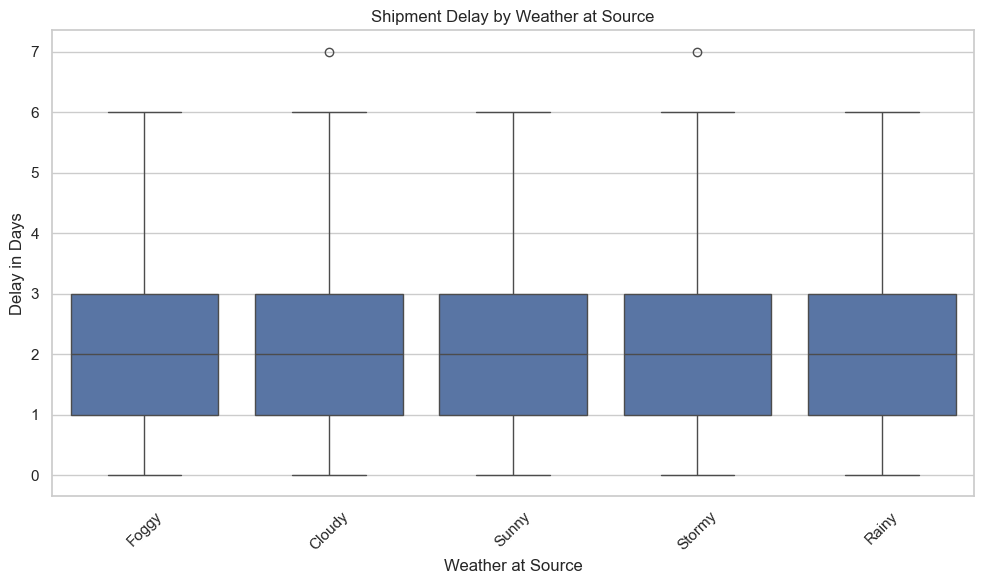

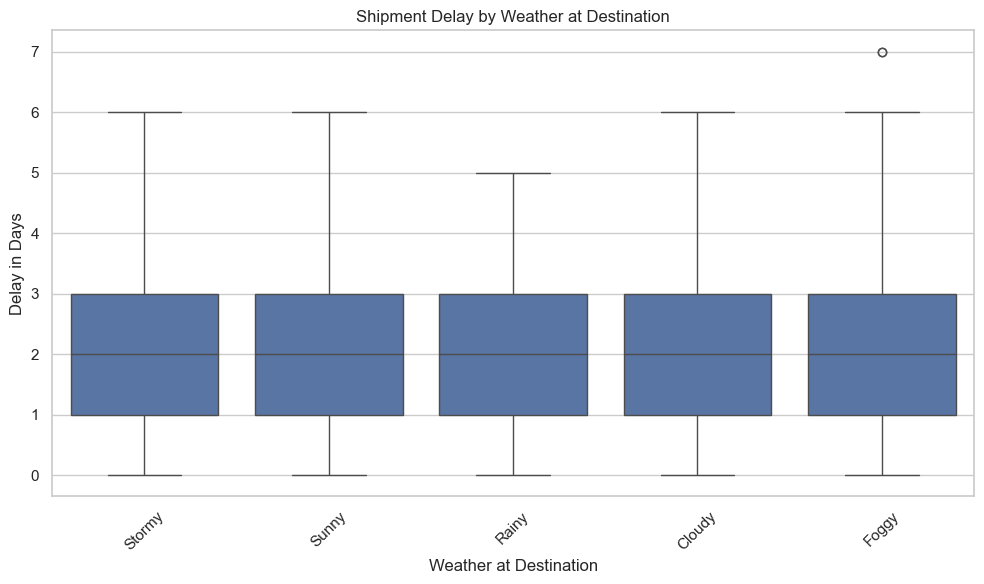

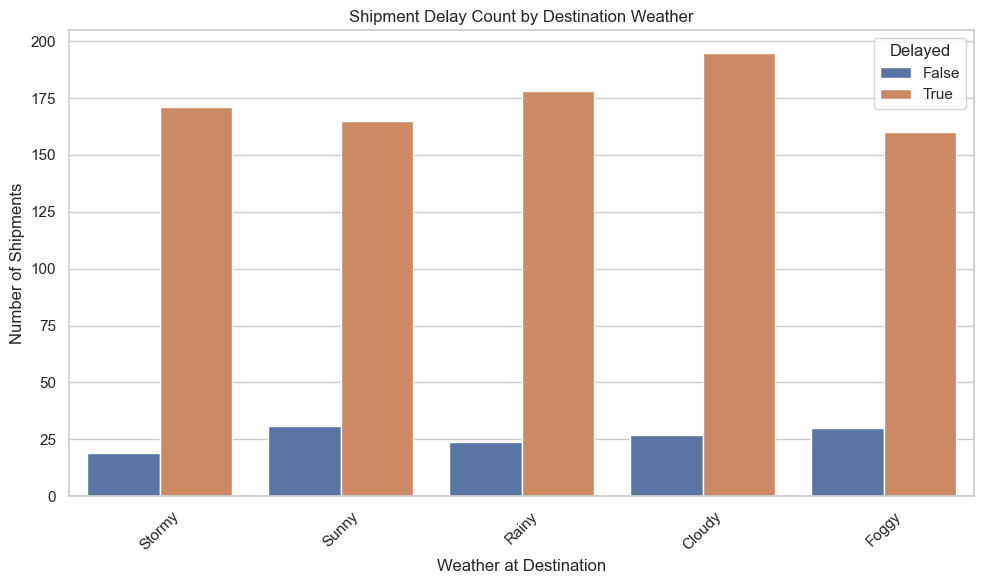

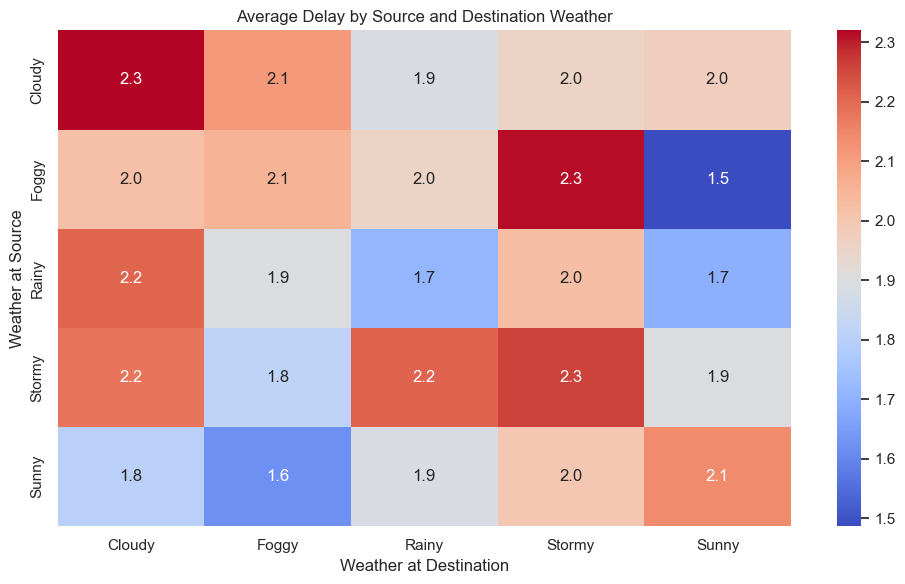

In [15]:

import seaborn as sns
import matplotlib.pyplot as plt

# Set a consistent style
sns.set(style="whitegrid")

# Plot 1: Box plot of delays by weather at source
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_source', y='delay_in_days', data=shipment_df)
plt.title('Shipment Delay by Weather at Source')
plt.xlabel('Weather at Source')
plt.ylabel('Delay in Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Box plot of delays by weather at destination
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_destination', y='delay_in_days', data=shipment_df)
plt.title('Shipment Delay by Weather at Destination')
plt.xlabel('Weather at Destination')
plt.ylabel('Delay in Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Count of delayed vs. on-time shipments by destination weather
shipment_df['delayed'] = shipment_df['delay_in_days'] > 0
plt.figure(figsize=(10, 6))
sns.countplot(x='weather_destination', hue='delayed', data=shipment_df)
plt.title('Shipment Delay Count by Destination Weather')
plt.xlabel('Weather at Destination')
plt.ylabel('Number of Shipments')
plt.legend(title='Delayed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 4: Heatmap of average delays grouped by source and destination weather
pivot_table = shipment_df.pivot_table(
    values='delay_in_days',
    index='weather_source',
    columns='weather_destination',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".1f")
plt.title('Average Delay by Source and Destination Weather')
plt.xlabel('Weather at Destination')
plt.ylabel('Weather at Source')
plt.tight_layout()
plt.show()
